In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from preprocessing import vocab_size
import matplotlib.pyplot as plt
from tensorflow import keras
from model_definition import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

Load in different data splits from files

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [4]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

In [5]:
np.shape(X_train)

(19076, 22)

In [19]:
X_train[0]

array([  3,   5,   7,  75,  74, 106, 128, 170, 183, 215,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

### Model Training

In [6]:
num_layers = 4
d_model = 40
dff = 864
num_heads = 10
dropout_rate = 0.22
epochs = 100
warmup_steps = 2500

num_classes = len(np.unique(y_train))
batch_size = 64
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

2023-03-17 00:14:29.866928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 00:14:33.165848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13635 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:60:00.0, compute capability: 7.5


In [8]:
def get_compiled_model():    
    learning_rate = CustomSchedule(d_model, warmup_steps=warmup_steps)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.83, beta_2=0.975, epsilon=2.073e-8)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation='relu'
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [12]:
import os
checkpoint_path = "model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.4f}]-val_loss:[{val_accuracy:.4f}].ckt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callback = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            initial_value_threshold=0.47,
            verbose=1)

In [20]:
model = get_compiled_model()
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1, 
                        callbacks=[my_callback], class_weight=class_weights)

Epoch 1/20


2023-03-17 00:19:21.356343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-17 00:19:21.905856: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8848015040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-17 00:19:21.905912: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-17 00:19:21.986419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-17 00:19:22.870392: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 [==============================] - ETA: 0s - loss: 1.9987 - accuracy: 0.1578
Epoch 1: val_accuracy did not improve from 0.48000
299/299 [==============================] - 27s 37ms/step - loss: 1.9987 - accuracy: 0.1578 - val_loss: 1.5008 - val_accuracy: 0.3628
Epoch 2/20
297/299 [============================>.] - ETA: 0s - loss: 1.5229 - accuracy: 0.3540
Epoch 2: val_accuracy did not improve from 0.48000
299/299 [==============================] - 6s 21ms/step - loss: 1.5226 - accuracy: 0.3542 - val_loss: 1.3898 - val_accuracy: 0.4449
Epoch 3/20
297/299 [============================>.] - ETA: 0s - loss: 1.4594 - accuracy: 0.3761
Epoch 3: val_accuracy did not improve from 0.48000
299/299 [==============================] - 6s 21ms/step - loss: 1.4588 - accuracy: 0.3762 - val_loss: 1.3003 - val_accuracy: 0.4560
Epoch 4/20
299/299 [==============================] - ETA: 0s - loss: 1.4397 - accuracy: 0.3843
Epoch 4: val_accuracy did not improve from 0.48000
299/299 [=================

In [16]:
model.build((19076, 22))
model.summary()

Model: "encoder_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  550536    
                                                                 
 sequential_4 (Sequential)   (19076, 22, 128)          43392     
                                                                 
 dense_10 (Dense)            multiple                  1161      
                                                                 
Total params: 595,089
Trainable params: 595,089
Non-trainable params: 0
_________________________________________________________________


### Training Plots

0.39510378241539

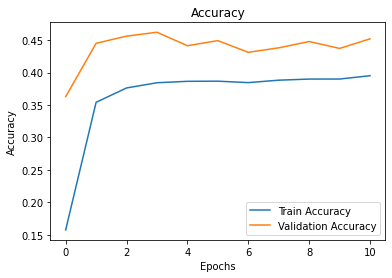

In [21]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

history.history['accuracy'][np.argmax(history.history['accuracy'])]

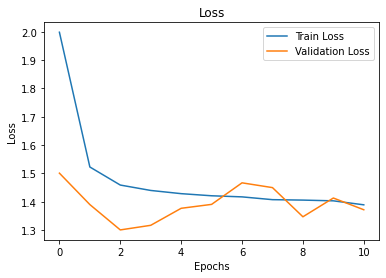

In [22]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

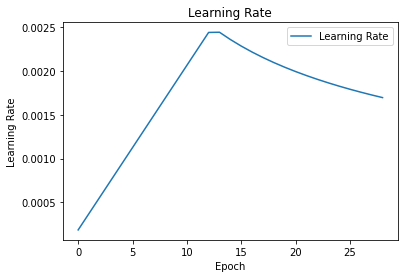

In [23]:
#learning_rate = MultiGPU(d_model, 
                         #step_stages=np.array([1, 20, 75, 120, 200]), 
                         #step_mult=np.array([1.3, 1.2]), 
                         #epochs_step=10.0)
learning_rate = CustomSchedule(d_model)
lr = np.array([])
for i in range(1, 30):
    lr = np.append(lr, learning_rate.__call__(i*300))
    #print(learning_rate.__call__(i).numpy())
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
#plt.axis([0, 300, 0, 0.000125])
plt.legend()


### Model Evaluation

In [24]:
pred = model.predict(X_test)

68/68 [==============================] - 1s 9ms/step


In [25]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [26]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.4483870967741935
+-1 accuracy 0.7847926267281106
+-2 accuracy 0.9368663594470046


Heatmap

<AxesSubplot:>

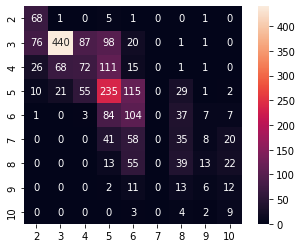

In [27]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

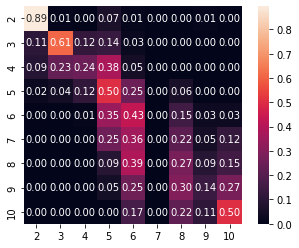

In [28]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)